In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.3
pymc3 version: 3.5
exoplanet version: 0.1.7.dev0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.io import ascii
from astropy import units as u
from astropy import constants
import astropy

deg = np.pi/180. # radians / degree
yr = 365.25 # days / year

In [4]:
def get_arrays(asciiTable, errDict=None, jitter=False):
    """
    Reformat ascii tables into pure numpy arrays of the right dimension.
    """
    
    output = []
    
    for star in ["Aa", "Ab"]:
    
        # get the RVs 
        rv = asciiTable["RV_" + star]
        
        if type(rv) is astropy.table.column.MaskedColumn:
            mask = ~rv.mask # values we want to keep when indexing
        else:
            mask = np.ones(len(rv), dtype="bool")

        rv = np.ascontiguousarray(rv[mask])
        date = np.ascontiguousarray(asciiTable["HJD"][mask])
        
        if errDict is None:
            err = np.ascontiguousarray(asciiTable["sigma_" + star][mask])
        else:
            err = np.ones(len(date), dtype=np.float64) * errDict[star]
            
        if jitter:
            err = np.ones(len(date), dtype=np.float64) * 0.1 # [km/s] assume a small error, since we'll infer.

        assert len(date) == len(rv), "date - rv length mismatch"
        assert len(date) == len(err), "date - err length mismatch"
            
        tup = (date, rv, err)

        output.append(tup)

    return output
    
    
# Do this to infer w/ jitter 
jitter=True

# load all the data
data_cfa = ascii.read("data/cfa.dat")
# cfa errors are provided in table 
cfa1,cfa2 = get_arrays(data_cfa, jitter=jitter)

data_keck = ascii.read("data/keck.dat", format="tab", fill_values=[("X", 0)])
err_keck = {"Aa":0.63, "Ab":0.85, "B":0.59} # km/s
keck1,keck2 = get_arrays(data_keck, err_keck, jitter=jitter)

data_feros = ascii.read("data/feros.dat")
err_feros = {"Aa":2.61, "Ab":3.59, "B":2.60} # km/s
feros1,feros2 = get_arrays(data_feros, err_feros, jitter=jitter)

data_dupont = ascii.read("data/dupont.dat", fill_values=[("X", 0)])
err_dupont = {"Aa":1.46, "Ab":2.34, "B":3.95} # km/s
dupont1,dupont2 = get_arrays(data_dupont, err_dupont, jitter=jitter)

data = [data_cfa, data_keck, data_feros, data_dupont]

# date is HJD + 2400000

In [5]:
data_cfa

<Table length=35>
   HJD     Orbital  RV_Aa   RV_Ab    RV_B  sigma_Aa sigma_Ab sigma_B
 float64   float64 float64 float64 float64 float64  float64  float64
---------- ------- ------- ------- ------- -------- -------- -------
50828.9583   0.225   -4.28   26.71    5.94      4.1     6.66    3.95
51177.0639   0.205   -3.93    23.0    7.29      2.9     4.71     2.8
51237.9189    0.95   39.18  -13.93    12.9     2.65      4.3    2.55
51595.9255   0.215   -4.61    24.7   10.15     2.65      4.3    2.55
51619.8713   0.901   33.65  -14.36    9.47     2.77     4.49    2.67
51621.8603   0.958   37.45  -25.56    4.56     2.77     4.49    2.67
51682.7086   0.703   16.36    3.66   14.07     2.37     3.84    2.28
51917.0057    0.42     0.9   23.18   10.16     2.77     4.49    2.67
51945.9559    0.25   -3.11   28.13    9.82     2.29     3.72    2.21
 51947.903   0.306   -1.91   26.98    8.36      4.1     6.66    3.95
       ...     ...     ...     ...     ...      ...      ...     ...
52653.9864    0.55    4.61    5.81   14.23     3.75     6.08    3.62
52722.7959   0.523    8.55   10.74   11.38      2.9     4.71     2.8
52771.6831   0.925   28.34  -20.69    5.19     3.24     5.27    3.12
53016.9925   0.958   36.04  -25.21    8.23     1.87     3.04     1.8
53035.9465   0.501    9.31   14.46    4.42     2.45     3.98    2.36
53127.7003   0.132   -5.98   34.88    9.67     2.16     3.51    2.08
53479.7427   0.225   -4.89   15.67    6.14      2.9     4.71     2.8
53781.9036   0.889    35.7  -16.91   10.66     2.37     3.84    2.28
53864.6736   0.262   -1.47   20.14    7.03     2.55     4.13    2.46
54136.9247   0.067  -10.99   31.18     9.4     2.77     4.49    2.67

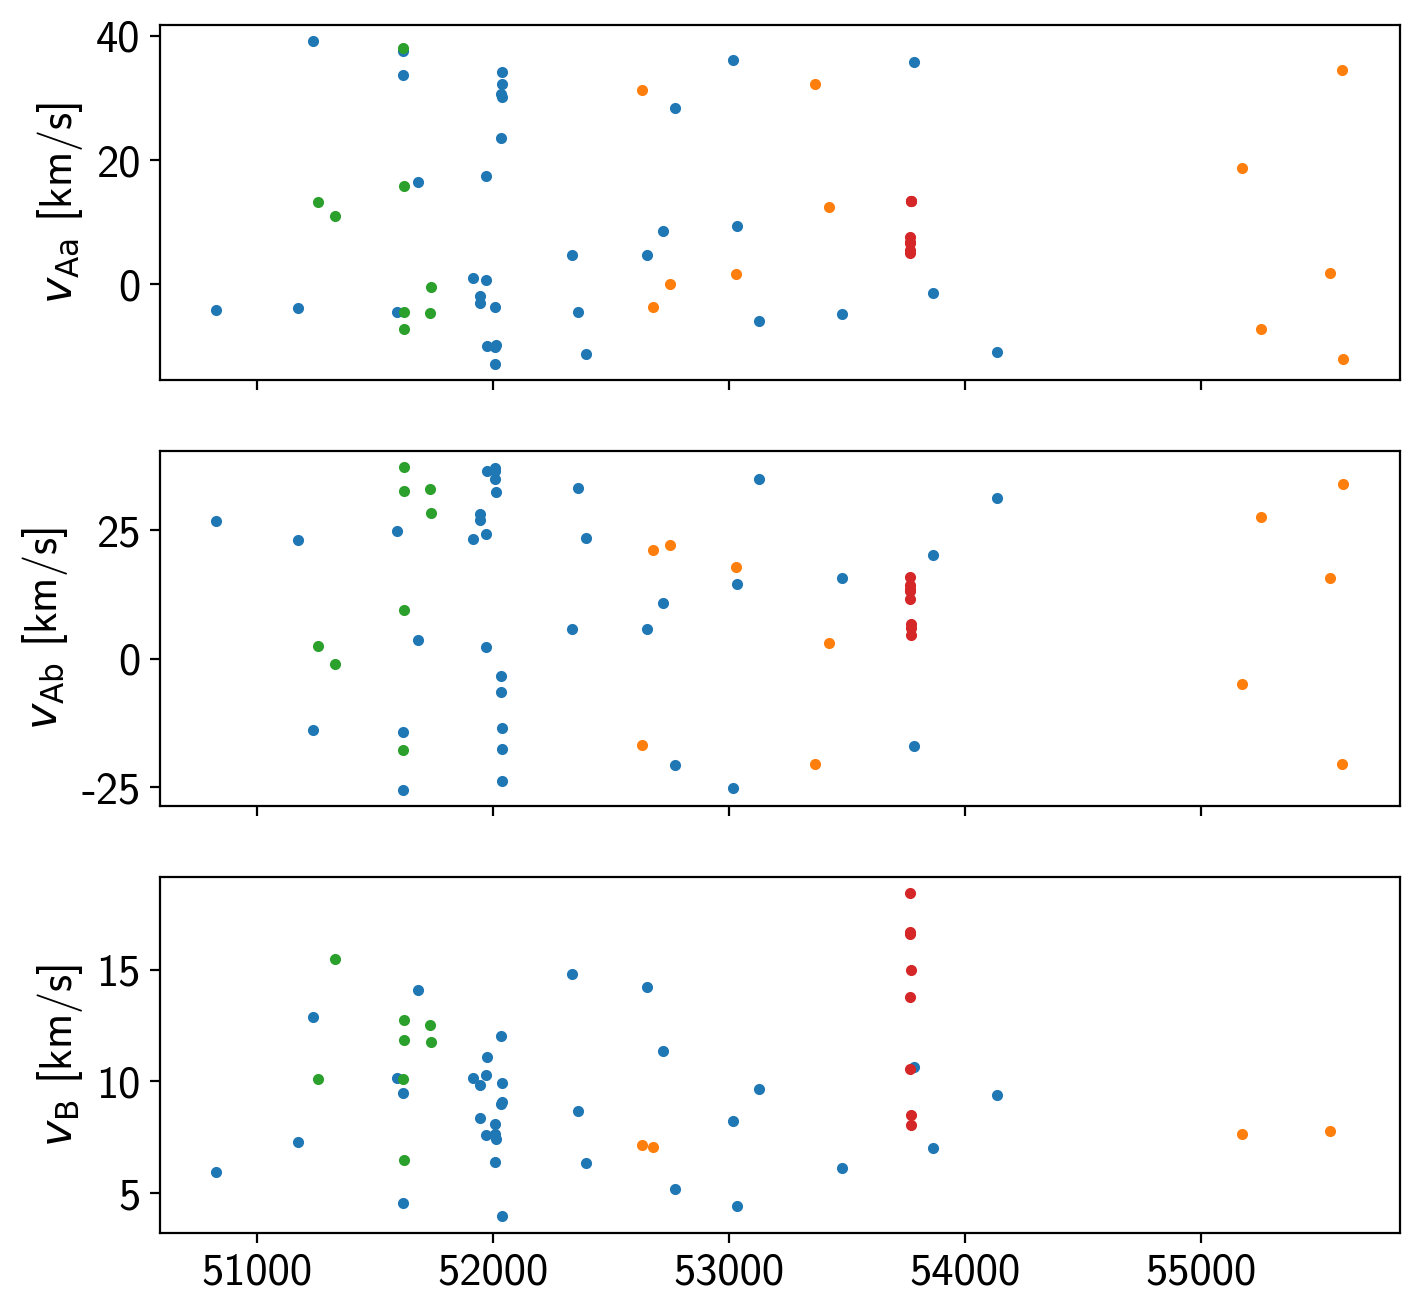

In [6]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(8,8))

pkw = {"marker":".", "ls":""}

for d in data:
    ax[0].plot(d["HJD"], d["RV_Aa"], **pkw)
    ax[0].set_ylabel(r"$v_\mathrm{Aa}$ [km/s]")
    
    ax[1].plot(d["HJD"], d["RV_Ab"], **pkw)
    ax[1].set_ylabel(r"$v_\mathrm{Ab}$ [km/s]")
    
    ax[2].plot(d["HJD"], d["RV_B"], **pkw)
    ax[2].set_ylabel(r"$v_\mathrm{B}$ [km/s]")
    
#     ax[1].plot(d[])

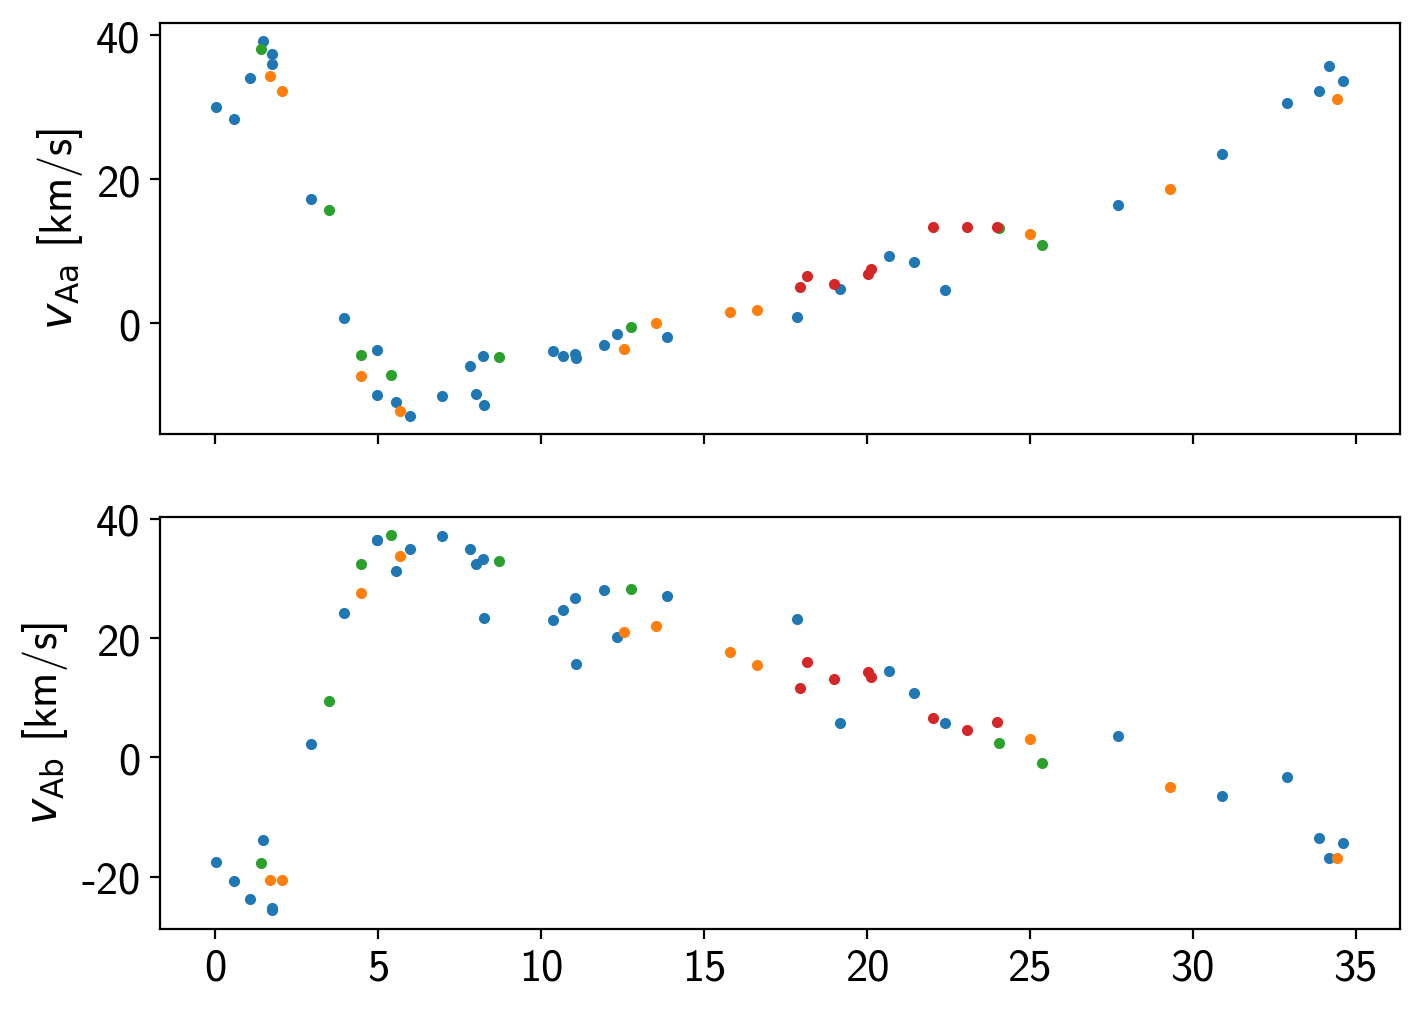

In [7]:
# try phase folding the data for Aa and Ab
P_A = 34.87846 # pm 0.00090 days
# P_A = 35.245521 # 

pkw = {"marker":".", "ls":""}

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(8,6))

for d in data:
    ax[0].plot(d["HJD"] % P_A, d["RV_Aa"], **pkw)
    ax[0].set_ylabel(r"$v_\mathrm{Aa}$ [km/s]")
    
    ax[1].plot(d["HJD"] % P_A, d["RV_Ab"], **pkw)
    ax[1].set_ylabel(r"$v_\mathrm{Ab}$ [km/s]")
    

In [8]:
# load the exoplanet part 
import pymc3 as pm 
import theano.tensor as tt

import corner

import exoplanet as xo
from exoplanet.distributions import Angle

In [9]:
np.log(0.01)

-4.605170185988091

In [10]:
xs_phase = np.linspace(0, 1, num=500)

with pm.Model() as model:

    # parameters
    # P, gamma, Ka, Kb, e, omegaA, T0
    # Delta CfA - Keck
    # Delta CfA - Feros
    # Delta CfA - du Pont
    # jitter for each instrument?

    # Parameters
    logKAa = pm.Uniform("logKAa", lower=0, upper=np.log(100),
                      testval=np.log(25)) # km/s
    logKAb = pm.Uniform("logKAb", lower=0, upper=np.log(100),
                      testval=np.log(25)) # km/s
    
    KAa = pm.Deterministic("KAa", tt.exp(logKAa))
    KAb = pm.Deterministic("KAb", tt.exp(logKAb))
    
    logP = pm.Uniform("logP", lower=0, upper=np.log(50.0),
                      testval=np.log(34.87846)) # days
    
    P = pm.Deterministic("P", tt.exp(logP))
    
    e = pm.Uniform("e", lower=0, upper=1, testval=0.62)
    
    omega = Angle("omega", testval=80.5 * deg) # omega_Aa

    gamma = pm.Uniform("gamma", lower=0, upper=20, testval=10.1)
    
    t_periastron = pm.Uniform("tPeri", lower=52690.0, upper=52720., testval=52704.55) # + 2400000 days

    orbit = xo.orbits.KeplerianOrbit(period=P, ecc=e, t_periastron=t_periastron, omega=omega)
    
    # since we have 4 instruments, we need to predict 4 different dataseries
    def get_RVs(t1, t2, offset):
        """
        Helper function for RVs. Closure should encapsulate current K1, K2 values, I hope.

        Args:
            orbit: exoplanet object
            t1: times to query for star 1
            t2 : times to query for star 2
            offset: (km/s)
            
        Returns:
            (rv1, rv2) [km/s] evaluated at those times with offset applied
       """
        rv1 = 1e-3 * orbit.get_radial_velocity(t1, 1e3 * tt.exp(logKAa)) + gamma + offset # km/s
        rv2 = 1e-3 * orbit.get_radial_velocity(t2, -1e3 * tt.exp(logKAb)) + gamma + offset # km/s

        return (rv1, rv2)
    
    offset_keck = pm.Normal("offsetKeck", mu=0.0, sd=5.0) # km/s
    offset_feros = pm.Normal("offsetFeros", mu=0.0, sd=5.0) # km/s
    offset_dupont = pm.Normal("offsetDupont", mu=0.0, sd=5.0) # km/s

    # expects m/s
    # dates are the first entry in each tuple of (date, rv, err)
    rv1_cfa, rv2_cfa = get_RVs(cfa1[0], cfa2[0], 0.0)
    rv1_keck, rv2_keck = get_RVs(keck1[0], keck2[0], offset_keck)
    rv1_feros, rv2_feros = get_RVs(feros1[0], feros2[0], offset_feros)
    rv1_dupont, rv2_dupont = get_RVs(dupont1[0], dupont2[0], offset_dupont)
    
    logjit_cfa = pm.Uniform("logjittercfa", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
    logjit_keck = pm.Uniform("logjitterkeck", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
    logjit_feros = pm.Uniform("logjitterferos", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
    logjit_dupont = pm.Uniform("logjitterdupont", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
    jit_cfa = pm.Deterministic("jitCfa", tt.exp(logjit_cfa))
    jit_keck = pm.Deterministic("jitKeck", tt.exp(logjit_keck))
    jit_feros = pm.Deterministic("jitFeros", tt.exp(logjit_feros))
    jit_dupont = pm.Deterministic("jitDupont", tt.exp(logjit_dupont))
    
    # get the total errors
    def get_err(rv_err, logjitter):
        return tt.sqrt(rv_err**2 + tt.exp(2*logjitter))
    
    # define the likelihoods
    pm.Normal("cfaRV1Obs", mu=rv1_cfa, observed=cfa1[1], sd=get_err(cfa1[2], logjit_cfa))
    pm.Normal("cfaRV2Obs", mu=rv2_cfa, observed=cfa2[1], sd=get_err(cfa2[2], logjit_cfa))
    pm.Normal("keckRV1Obs", mu=rv1_keck, observed=keck1[1], sd=get_err(keck1[2], logjit_keck))
    pm.Normal("keckRV2Obs", mu=rv2_keck, observed=keck2[1], sd=get_err(keck2[2], logjit_keck))
    pm.Normal("ferosRV1Obs", mu=rv1_feros, observed=feros1[1], sd=get_err(feros1[2], logjit_feros))
    pm.Normal("ferosRV2Obs", mu=rv2_feros, observed=feros2[1], sd=get_err(feros2[2], logjit_feros))
    pm.Normal("dupontRV1Obs", mu=rv1_dupont, observed=dupont1[1], sd=get_err(dupont1[2], logjit_dupont))
    pm.Normal("dupontRV2Obs", mu=rv2_dupont, observed=dupont2[1], sd=get_err(dupont2[2], logjit_dupont))
    
    # Compute the phased RV signal
    # phased since periastron 
    
    t_dense = xs_phase * P + t_periastron 

    rv1, rv2 = get_RVs(t_dense, t_dense, 0.0)
    
    rv1_dense = pm.Deterministic("RV1Dense", rv1)
    rv2_dense = pm.Deterministic("RV2Dense", rv2)

In [11]:
with model:
    map_sol = xo.optimize()

optimizing logp for variables: ['logjitterdupont_interval__', 'logjitterferos_interval__', 'logjitterkeck_interval__', 'logjittercfa_interval__', 'offsetDupont', 'offsetFeros', 'offsetKeck', 'tPeri_interval__', 'gamma_interval__', 'omega_angle__', 'e_interval__', 'logP_interval__', 'logKAb_interval__', 'logKAa_interval__']
message: Optimization terminated successfully.
logp: -923.2602523430069 -> -294.8884659640766


In [12]:
sampler = xo.PyMC3Sampler(window=100, finish=200)
with model:
    burnin = sampler.tune(tune=2500, start=map_sol, step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=3000)

Sampling 4 chains: 100%|██████████| 808/808 [00:01<00:00, 582.88draws/s]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logjitterdupont, logjitterferos, logjitterkeck, logjittercfa, offsetDupont, offsetFeros, offsetKeck, tPeri, gamma, omega, e, logP, logKAb, logKAa]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:14<00:00, 816.11draws/s]


/Users/ianczekala/.build/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c28683438>,
      dtype=object)

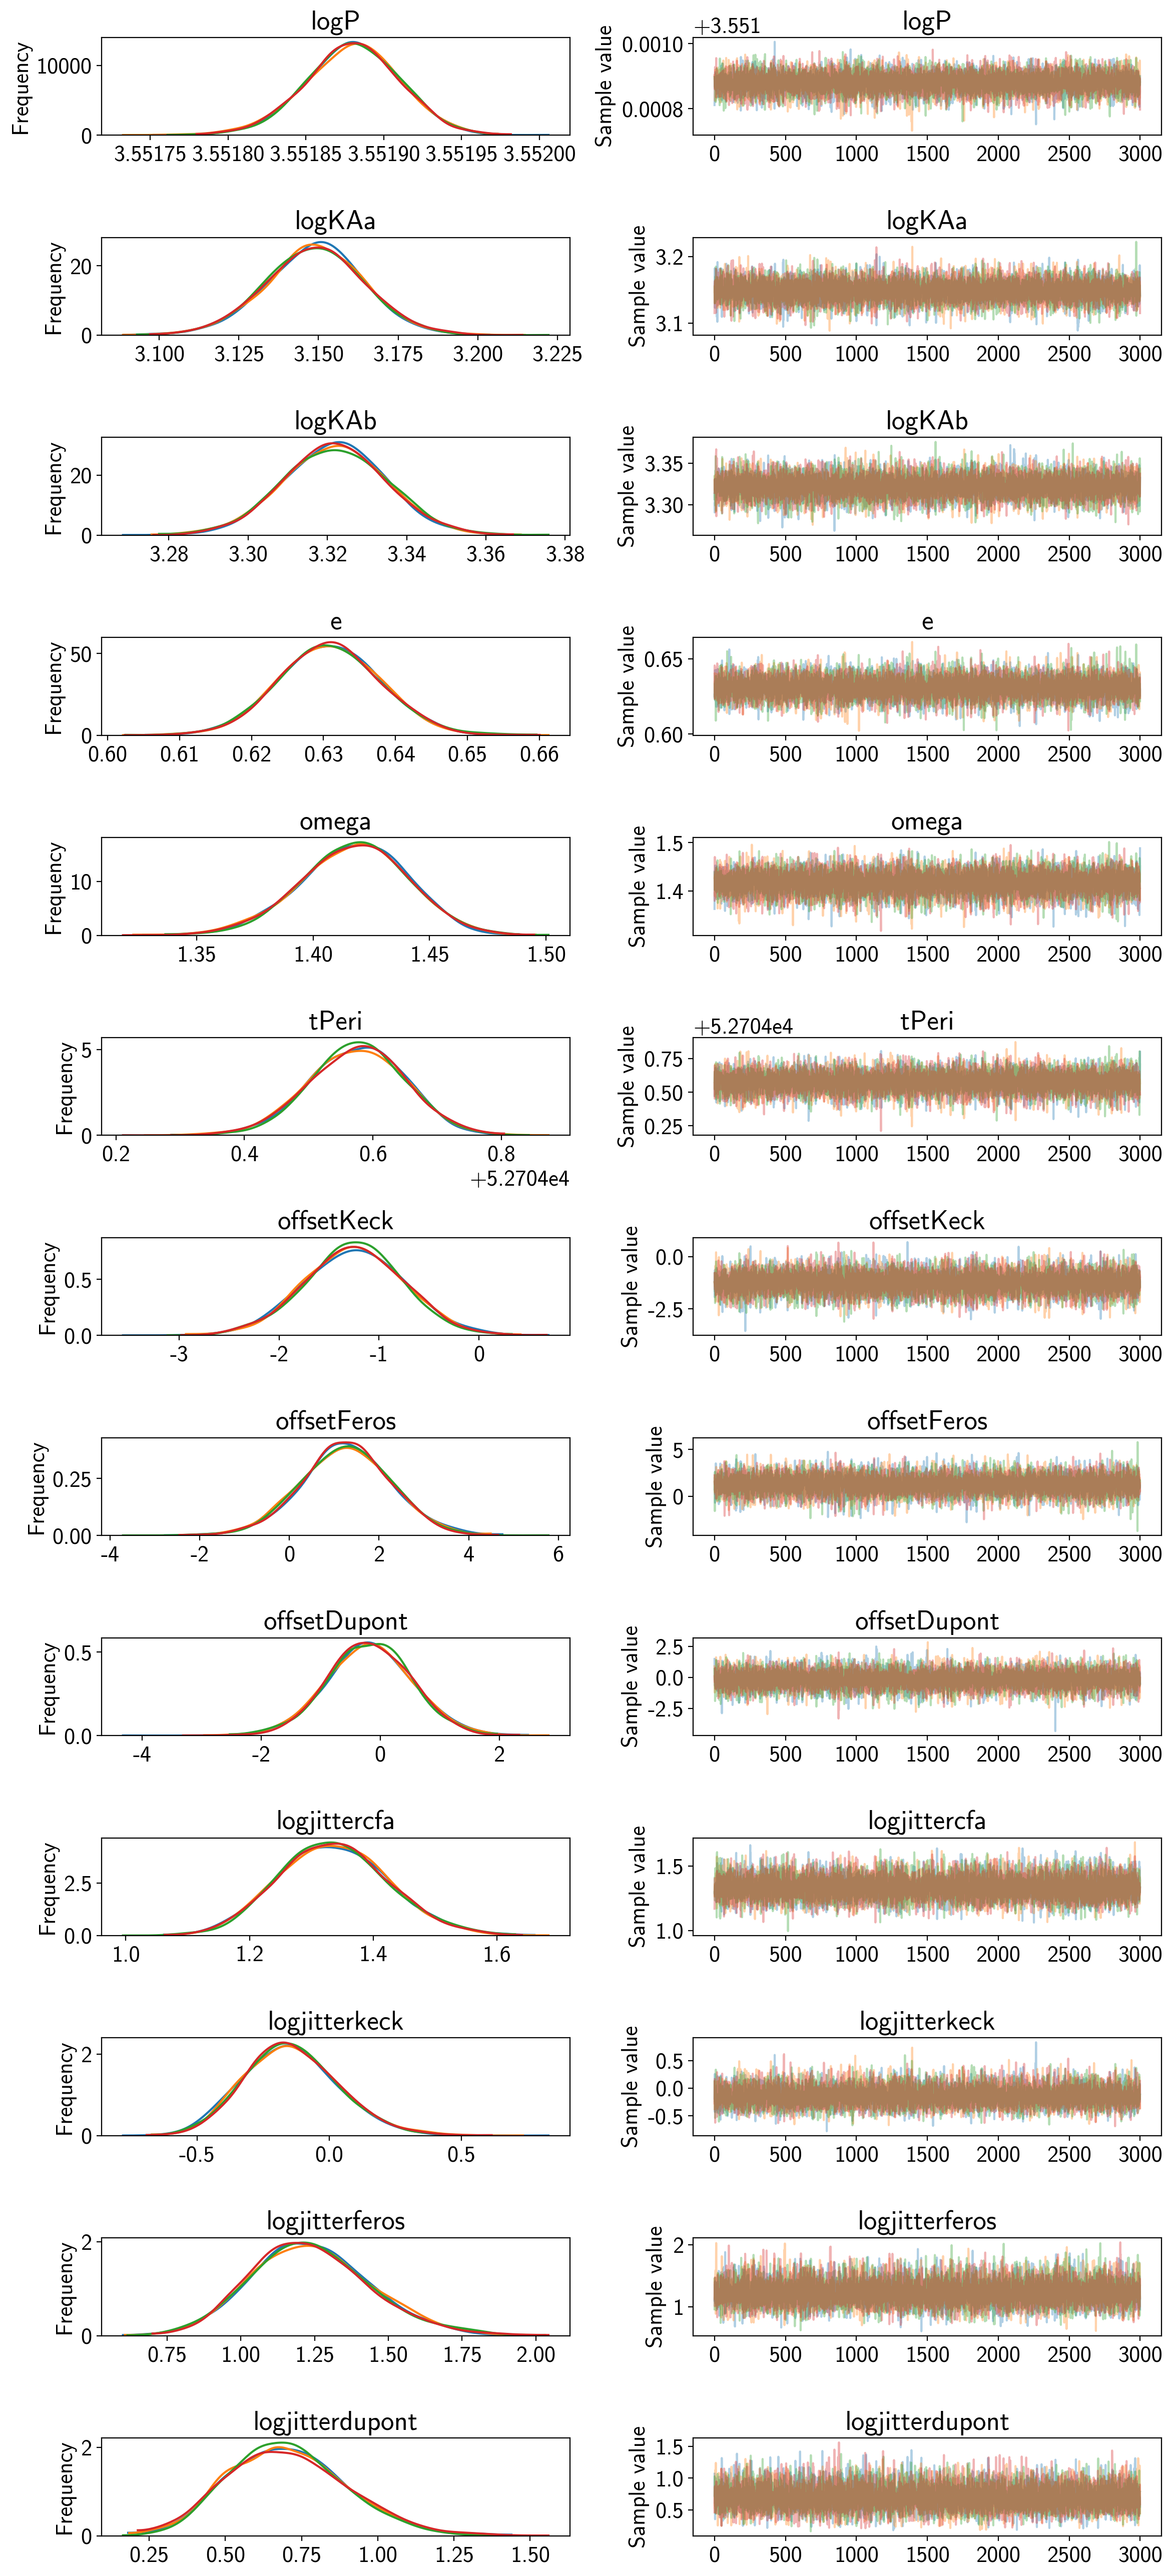

In [13]:
pm.traceplot(trace, varnames=["logP", "logKAa", "logKAb", "e", "omega", "tPeri",
                              "offsetKeck", "offsetFeros", "offsetDupont", 
                              "logjittercfa", "logjitterkeck", "logjitterferos", "logjitterdupont"])

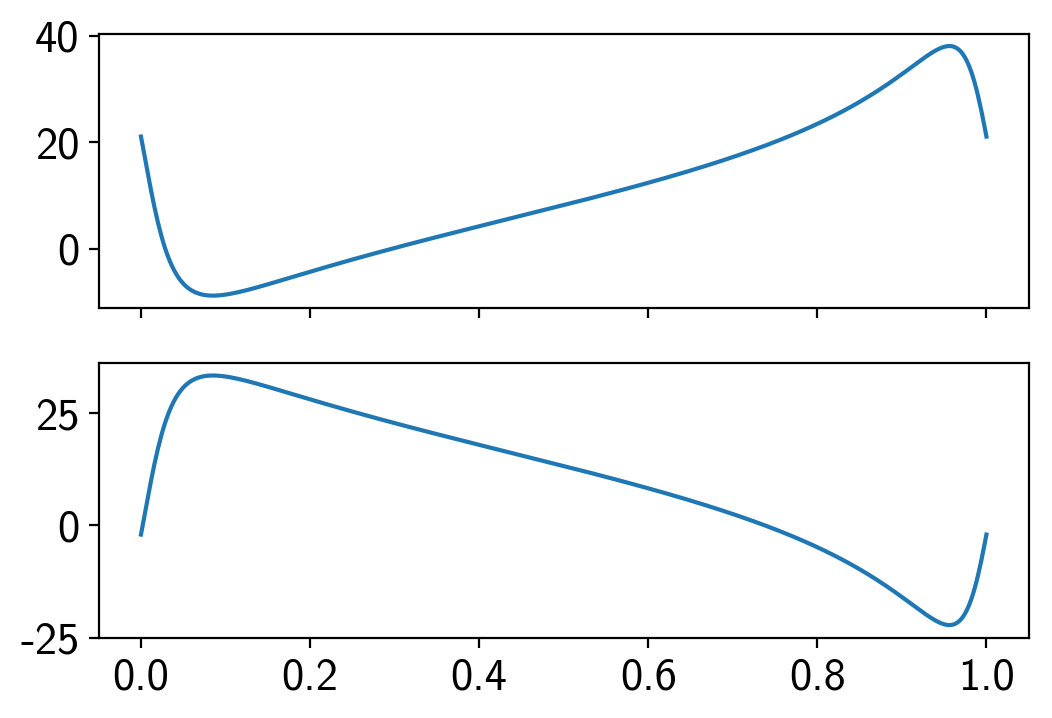

In [67]:
with model:
    rv1 = xo.eval_in_model(rv1_dense, map_sol)
    rv2 = xo.eval_in_model(rv2_dense, map_sol)
    
    fig, ax = plt.subplots(nrows=2, sharex=True)
    ax[0].plot(xs_phase, rv1)
    ax[1].plot(xs_phase, rv2)

To assess the quality of the fit, we should go and plot the fit and residuals for all of the data points individually and together.

The phase-folding plot only really works for a fixed value of `tperi`, `P`. So, we can plot the MAP phase fold. But other than that it only makes sense to plot the orbit scatter on the actual series of points (minus any offset, too). 

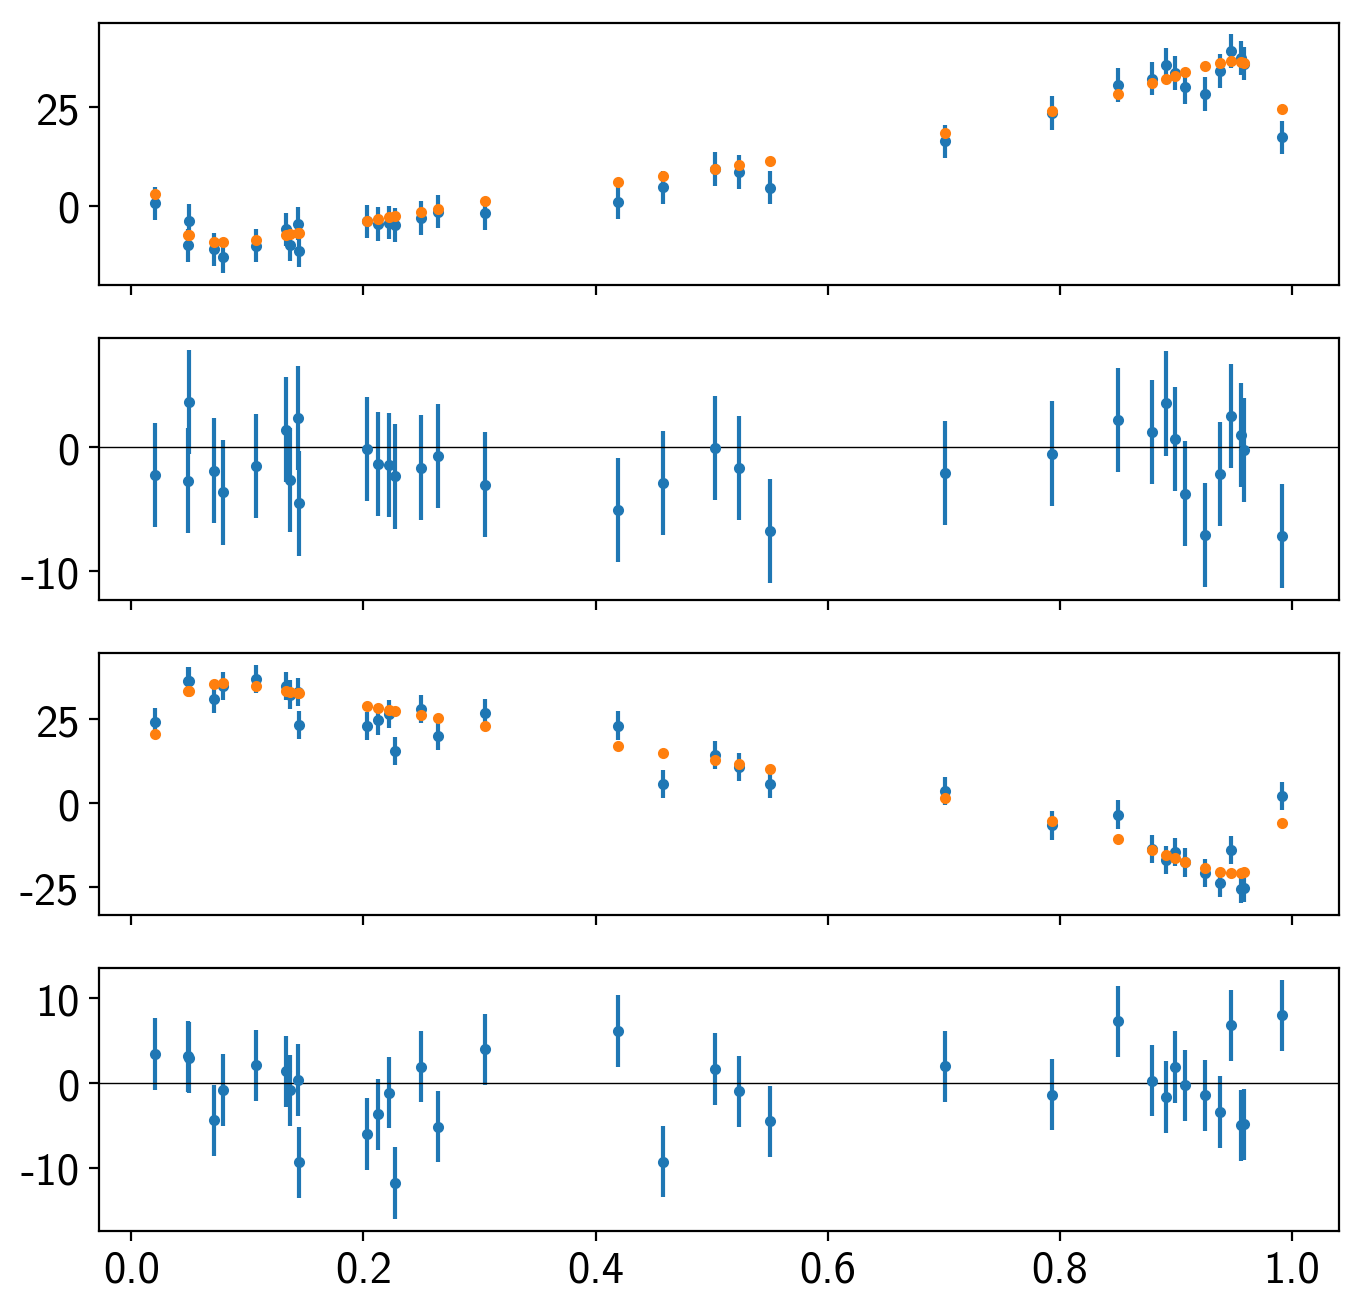

In [133]:
pkw = {"marker":".", "ls":""}
ekw = {"marker":".", "ls":""}

def get_phase(dates, P, tperi):
    return ((dates - tperi) % P) / P

# nsamples = 10
# choices = np.random.choice(np.arange(len(trace)), size=nsamples)

# just choose one representative sample
np.random.seed(43)
choice = np.random.choice(np.arange(len(trace)))

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(8,8))

with model:
    
    pos = trace[choice] 

    tperi = pos["tPeri"]
    P = pos["P"]
    logjit = pos["logjittercfa"]

    err1 = np.sqrt(cfa1[2]**2 + np.exp(2 * logjit))
    err2 = np.sqrt(cfa2[2]**2 + np.exp(2 * logjit))

    
    phase1 = get_phase(cfa1[0], P, tperi)
    rv1 = xo.eval_in_model(rv1_cfa, pos)
    ax[0].errorbar(phase1, cfa1[1], yerr=err1, **ekw, zorder=0)
    ax[0].plot(phase1, rv1, **pkw, zorder=1)
    
    ax[1].axhline(0.0, color="k", lw=0.5)
    ax[1].errorbar(phase1, cfa1[1] - rv1, yerr=err1, **ekw)
    
    
    phase2 = get_phase(cfa2[0], P, tperi)
    rv2 = xo.eval_in_model(rv2_cfa, pos)
    ax[2].errorbar(phase2, cfa2[1], yerr=err2, **ekw, zorder=0)
    ax[2].plot(phase2, rv2, **pkw, zorder=1)
    
    ax[3].axhline(0.0, color="k", lw=0.5)
    ax[3].errorbar(phase2, cfa2[1] - rv2, yerr=err2, **ekw)
    

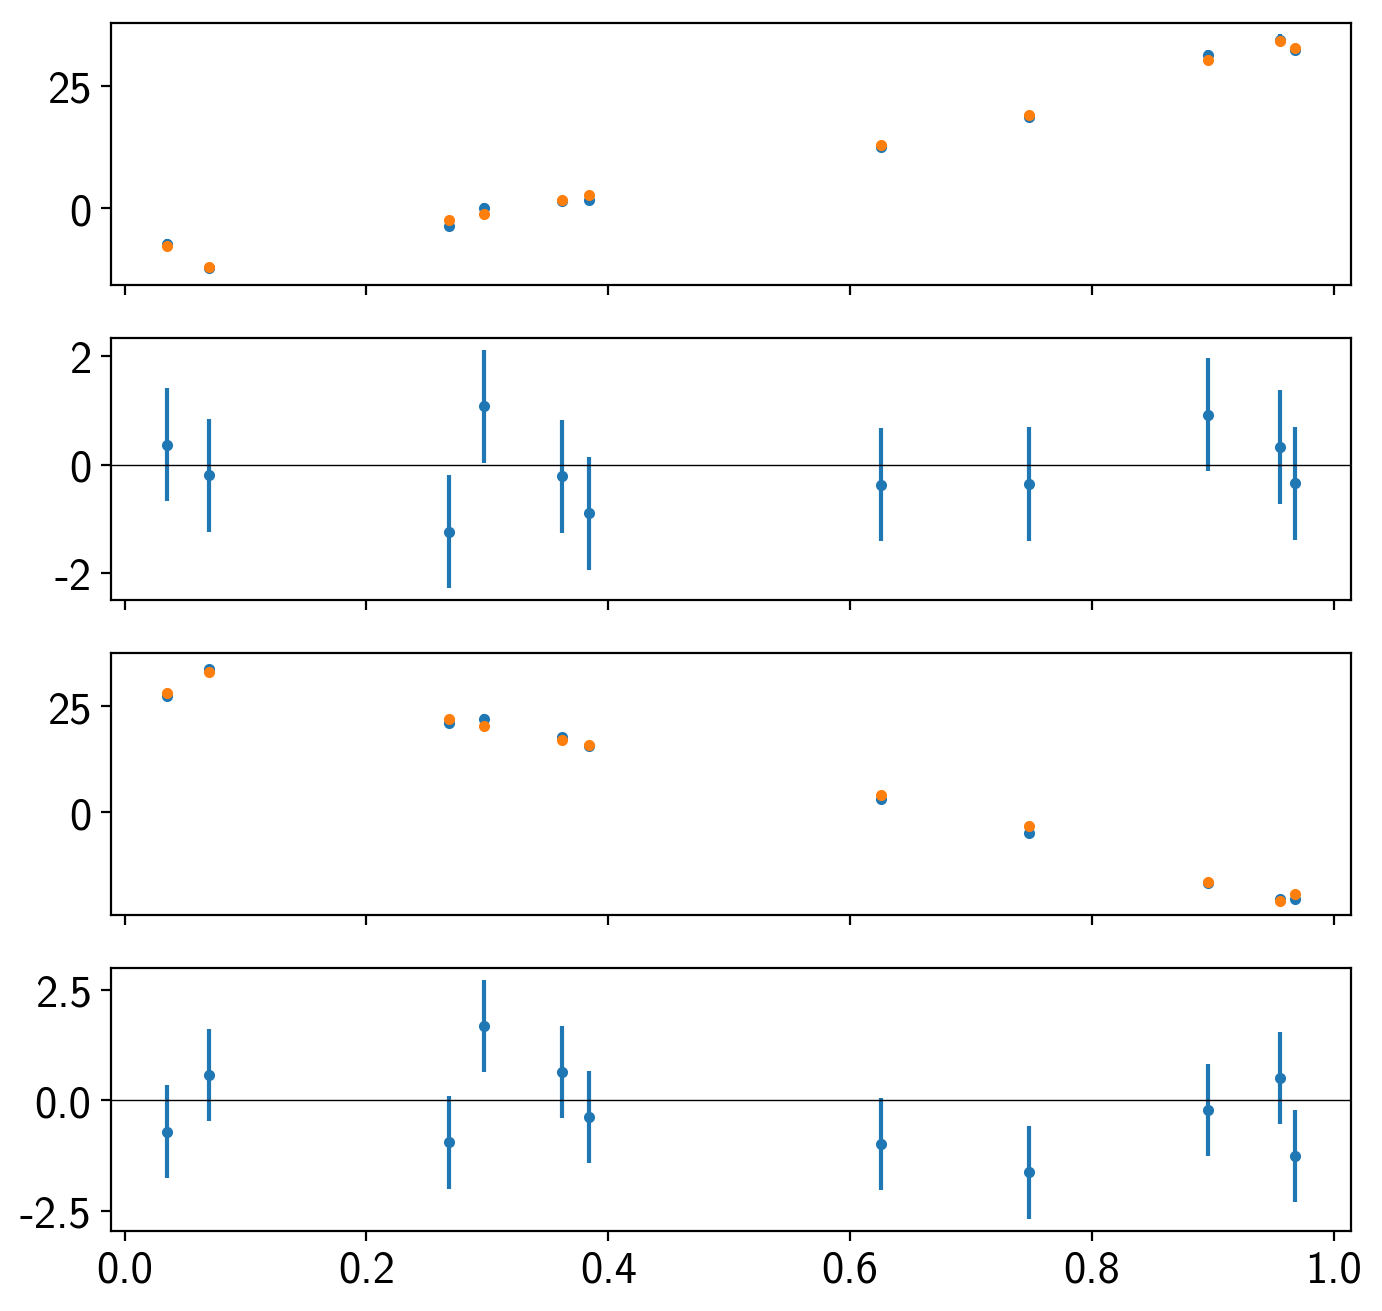

In [135]:
pkw = {"marker":".", "ls":""}
ekw = {"marker":".", "ls":""}

def get_phase(dates, P, tperi):
    return ((dates - tperi) % P) / P

# nsamples = 10
# choices = np.random.choice(np.arange(len(trace)), size=nsamples)

# just choose one representative sample
np.random.seed(41)
choice = np.random.choice(np.arange(len(trace)))

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(8,8))

with model:
    
    pos = trace[choice] 

    tperi = pos["tPeri"]
    P = pos["P"]
    
    logjit = pos["logjitterkeck"]

    err1 = np.sqrt(keck1[2]**2 + np.exp(2 * logjit))
    err2 = np.sqrt(keck2[2]**2 + np.exp(2 * logjit))
    
    phase1 = get_phase(keck1[0], P, tperi)
    rv1 = xo.eval_in_model(rv1_keck, pos)
    ax[0].errorbar(phase1, keck1[1], yerr=err1, **ekw, zorder=0)
    ax[0].plot(phase1, rv1, **pkw, zorder=1)
    
    ax[1].axhline(0.0, color="k", lw=0.5)
    ax[1].errorbar(phase1, keck1[1] - rv1, yerr=err1, **ekw)
    
    phase2 = get_phase(keck2[0], P, tperi)
    rv2 = xo.eval_in_model(rv2_keck, pos)
    ax[2].errorbar(phase2, keck2[1], yerr=err2, **ekw, zorder=0)
    ax[2].plot(phase2, rv2, **pkw, zorder=1)
    
    ax[3].axhline(0.0, color="k", lw=0.5)
    ax[3].errorbar(phase2, keck2[1] - rv2, yerr=err2, **ekw)    

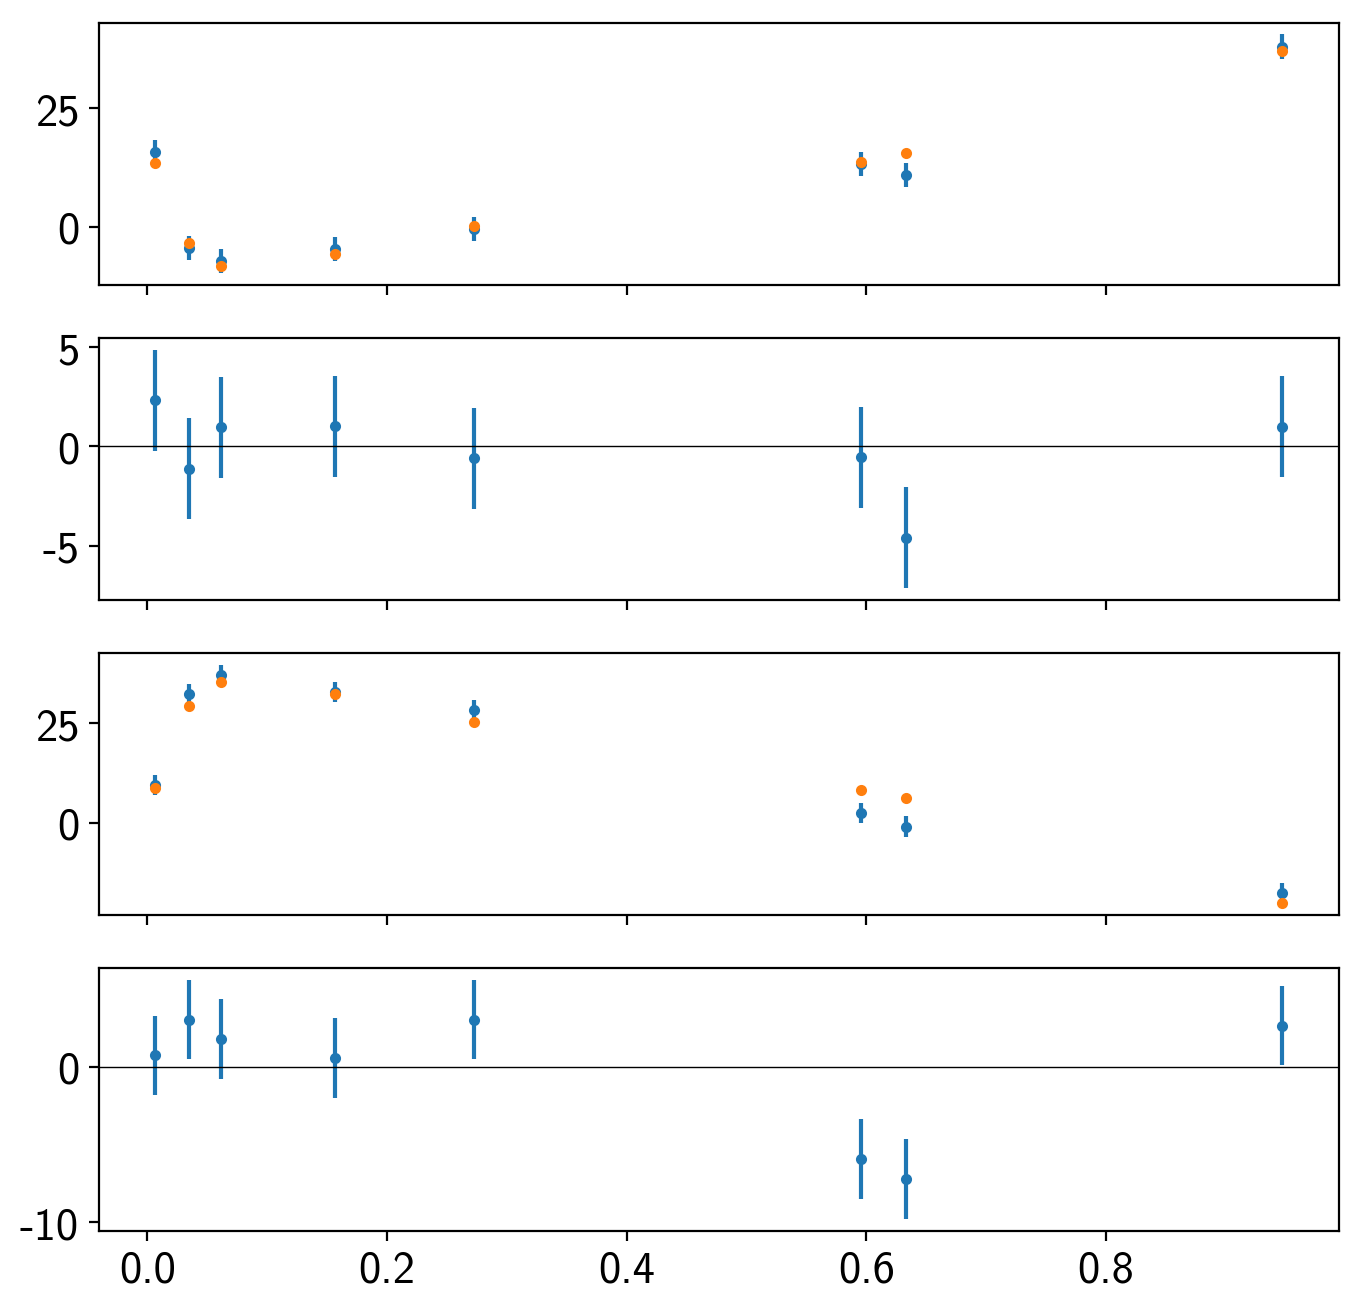

In [138]:
pkw = {"marker":".", "ls":""}
ekw = {"marker":".", "ls":""}

def get_phase(dates, P, tperi):
    return ((dates - tperi) % P) / P

# nsamples = 10
# choices = np.random.choice(np.arange(len(trace)), size=nsamples)

# just choose one representative sample
np.random.seed(43)
choice = np.random.choice(np.arange(len(trace)))

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(8,8))

with model:
    
    pos = trace[choice] 

    tperi = pos["tPeri"]
    P = pos["P"]
    logjit = pos["logjitterferos"]

    err1 = np.sqrt(feros1[2]**2 + np.exp(2 * logjit))
    err2 = np.sqrt(feros2[2]**2 + np.exp(2 * logjit))
    
    phase1 = get_phase(feros1[0], P, tperi)
    rv1 = xo.eval_in_model(rv1_feros, pos)
    ax[0].errorbar(phase1, feros1[1], yerr=err1, **ekw, zorder=0)
    ax[0].plot(phase1, rv1, **pkw, zorder=1)
    
    ax[1].axhline(0.0, color="k", lw=0.5)
    ax[1].errorbar(phase1, feros1[1] - rv1, yerr=err1, **ekw)
    
    
    phase2 = get_phase(feros2[0], P, tperi)
    rv2 = xo.eval_in_model(rv2_feros, pos)
    ax[2].errorbar(phase2, feros2[1], yerr=err2, **ekw, zorder=0)
    ax[2].plot(phase2, rv2, **pkw, zorder=1)
    
    ax[3].axhline(0.0, color="k", lw=0.5)
    ax[3].errorbar(phase2, feros2[1] - rv2, yerr=err2, **ekw)

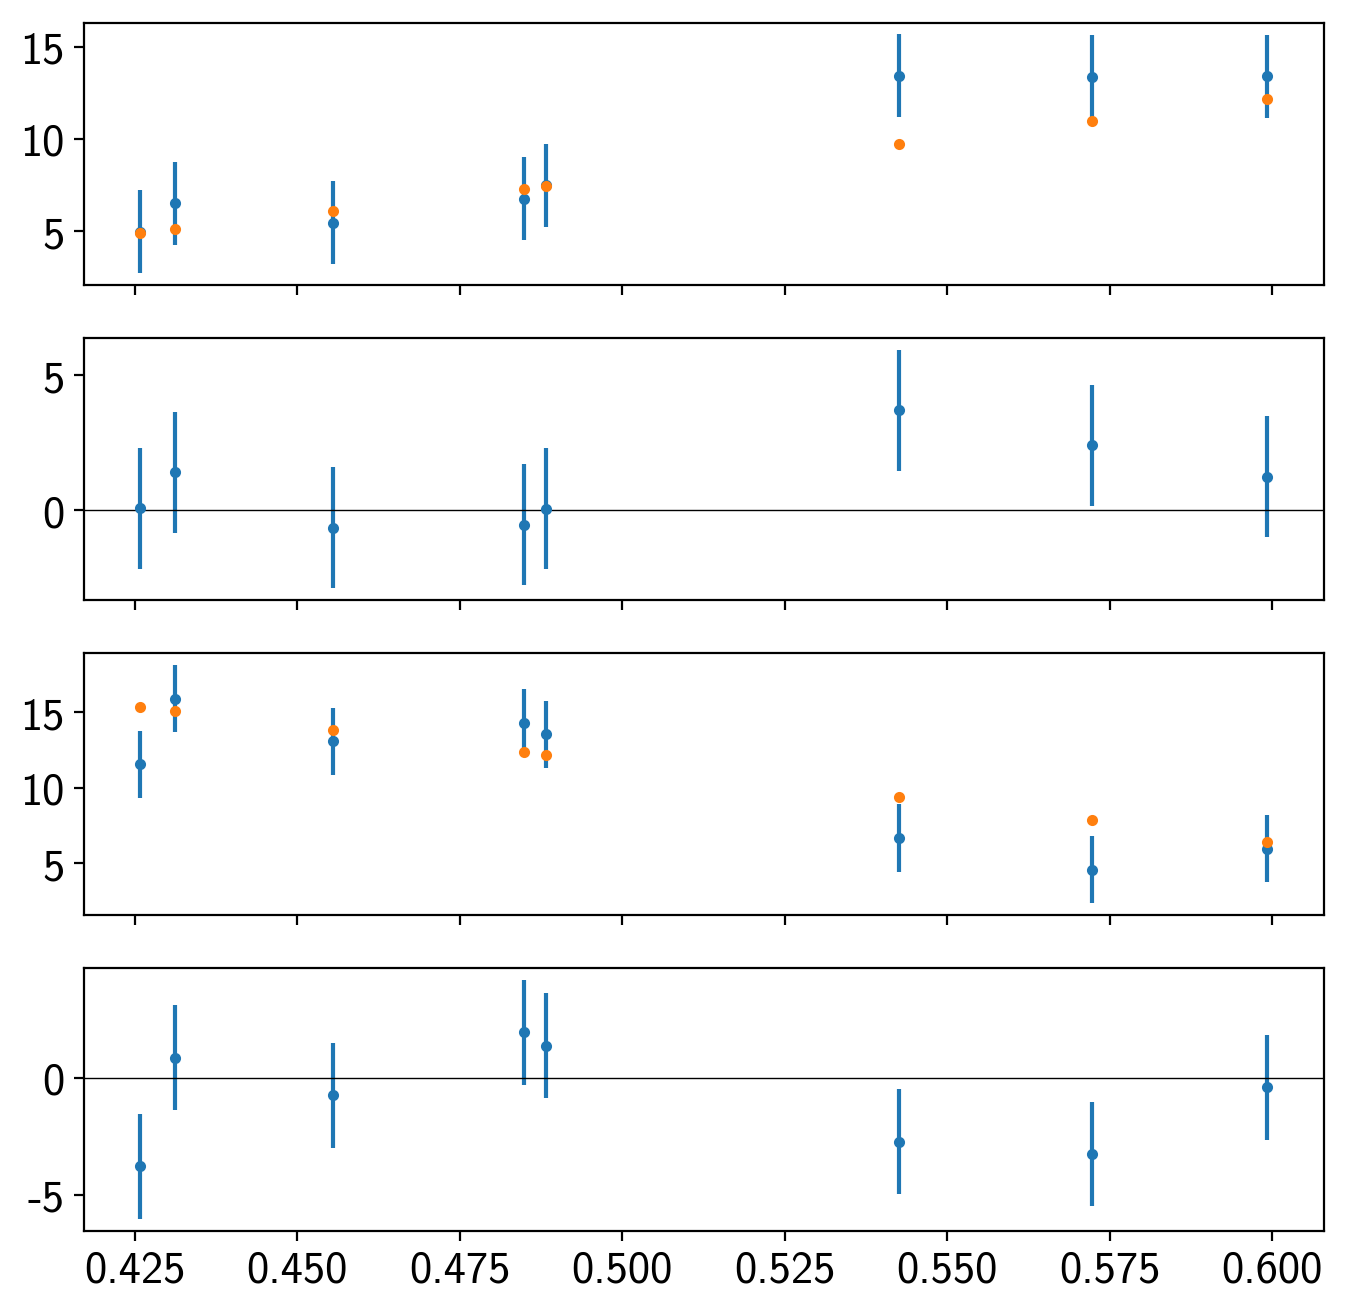

In [140]:
pkw = {"marker":".", "ls":""}
ekw = {"marker":".", "ls":""}

def get_phase(dates, P, tperi):
    return ((dates - tperi) % P) / P

# nsamples = 10
# choices = np.random.choice(np.arange(len(trace)), size=nsamples)

# just choose one representative sample
np.random.seed(43)
choice = np.random.choice(np.arange(len(trace)))

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(8,8))

with model:
    
    pos = trace[choice] 

    tperi = pos["tPeri"]
    P = pos["P"]

    logjit = pos["logjitterdupont"]

    err1 = np.sqrt(dupont1[2]**2 + np.exp(2 * logjit))
    err2 = np.sqrt(dupont2[2]**2 + np.exp(2 * logjit))
    
    phase1 = get_phase(dupont1[0], P, tperi)
    rv1 = xo.eval_in_model(rv1_dupont, pos)
    ax[0].errorbar(phase1, dupont1[1], yerr=err1, **ekw, zorder=0)
    ax[0].plot(phase1, rv1, **pkw, zorder=1)
    
    ax[1].axhline(0.0, color="k", lw=0.5)
    ax[1].errorbar(phase1, dupont1[1] - rv1, yerr=err1, **ekw)
    
    
    phase2 = get_phase(dupont2[0], P, tperi)
    rv2 = xo.eval_in_model(rv2_dupont, pos)
    ax[2].errorbar(phase2, dupont2[1], yerr=err2, **ekw, zorder=0)
    ax[2].plot(phase2, rv2, **pkw, zorder=1)
    
    ax[3].axhline(0.0, color="k", lw=0.5)
    ax[3].errorbar(phase2, dupont2[1] - rv2, yerr=err2, **ekw)

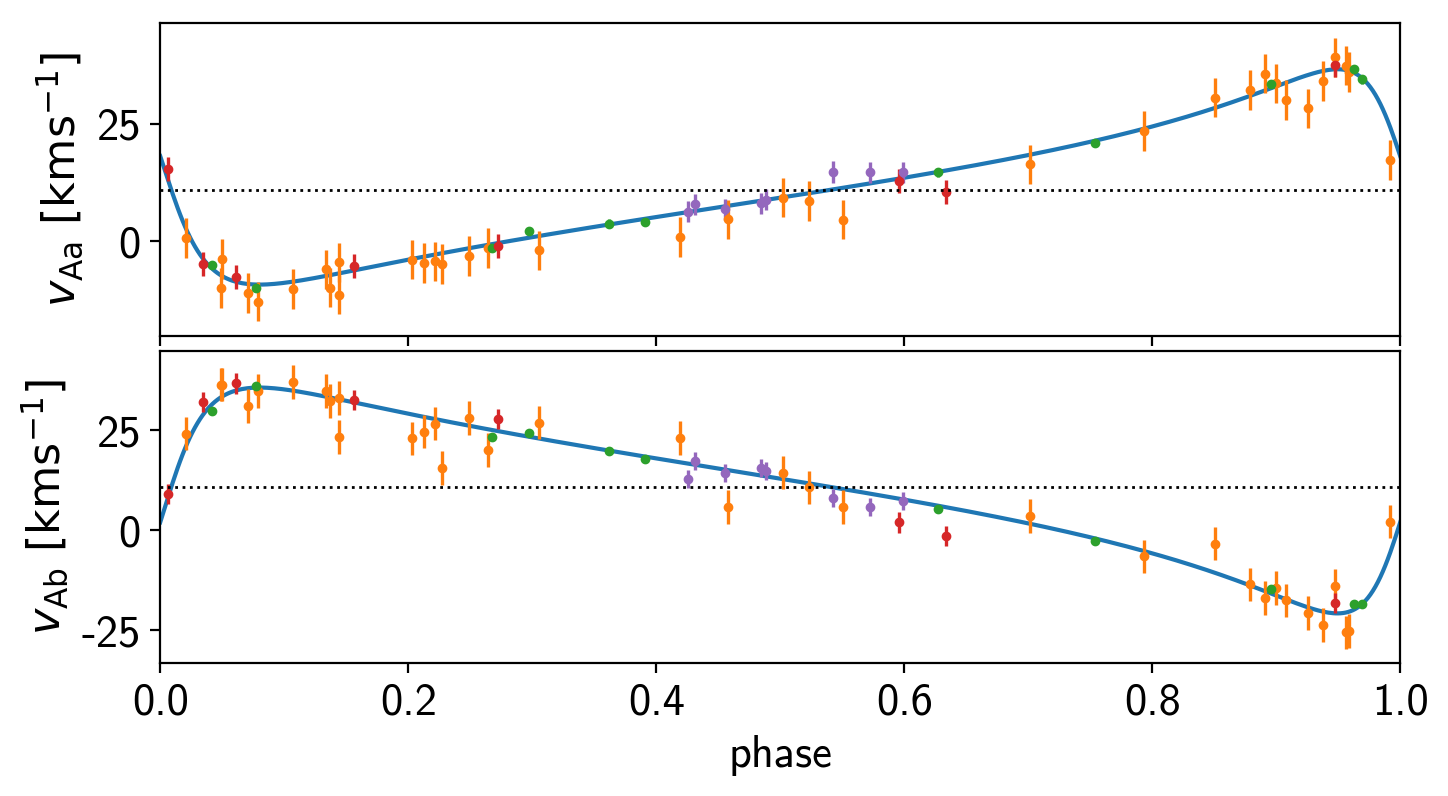

In [167]:
# plot everything ontop in a single plot

pkw = {"marker":".", "ls":""}
ekw = {"marker":".", "ms":5.0, "ls":"", "elinewidth":1.2}

def get_phase(dates, pos):
    return ((dates - pos["tPeri"]) % pos["P"]) / pos["P"]

# nsamples = 10
# choices = np.random.choice(np.arange(len(trace)), size=nsamples)

# just choose one representative sample
np.random.seed(43)
choice = np.random.choice(np.arange(len(trace)))

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(8,4))

with model:
    
    pos = trace[choice] 

    tperi = pos["tPeri"]
    P = pos["P"]

    # calculate the errors for each instrument
    cfa_err1 = np.sqrt(cfa1[2]**2 + np.exp(2 * pos["logjittercfa"]))
    cfa_err2 = np.sqrt(cfa2[2]**2 + np.exp(2 * pos["logjittercfa"]))
    
    keck_err1 = np.sqrt(keck1[2]**2 + np.exp(2 * pos["logjitterkeck"]))
    keck_err2 = np.sqrt(keck2[2]**2 + np.exp(2 * pos["logjitterkeck"]))
    
    feros_err1 = np.sqrt(feros1[2]**2 + np.exp(2 * pos["logjitterferos"]))
    feros_err2 = np.sqrt(feros2[2]**2 + np.exp(2 * pos["logjitterferos"]))
    
    dupont_err1 = np.sqrt(dupont1[2]**2 + np.exp(2 * pos["logjitterdupont"]))
    dupont_err2 = np.sqrt(dupont2[2]**2 + np.exp(2 * pos["logjitterdupont"]))
        
    # plot RV1 model
    ax[0].axhline(pos["gamma"], lw=1.0, color="k", ls=":")
    ax[0].plot(xs_phase, pos["RV1Dense"], zorder=-1)
    
    # at data locations
    ax[0].errorbar(get_phase(cfa1[0], pos), cfa1[1], yerr=cfa_err1, **ekw, zorder=0)
    ax[0].errorbar(get_phase(keck1[0], pos), keck1[1] - pos["offsetKeck"], yerr=keck_err1, **ekw, zorder=0)
    ax[0].errorbar(get_phase(feros1[0], pos), feros1[1] - pos["offsetFeros"], yerr=feros_err1, **ekw, zorder=0)
    ax[0].errorbar(get_phase(dupont1[0], pos), dupont1[1] - pos["offsetDupont"], yerr=dupont_err1, **ekw, zorder=0)
    
    # plot RV2
    ax[1].axhline(pos["gamma"], lw=1.0, color="k", ls=":")
    ax[1].plot(xs_phase, pos["RV2Dense"], zorder=-1)
    
    # at data locations
    ax[1].errorbar(get_phase(cfa2[0], pos), cfa2[1], yerr=cfa_err2, **ekw, zorder=0)
    ax[1].errorbar(get_phase(keck2[0], pos), keck2[1] - pos["offsetKeck"], yerr=keck_err2, **ekw, zorder=0)
    ax[1].errorbar(get_phase(feros2[0], pos), feros2[1] - pos["offsetFeros"], yerr=feros_err2, **ekw, zorder=0)
    ax[1].errorbar(get_phase(dupont2[0], pos), dupont2[1] - pos["offsetDupont"], yerr=dupont_err2, **ekw, zorder=0)

    ax[1].set_xlim(0.0, 1.0)
    ax[0].set_ylabel(r"$v_\mathrm{Aa}$ $[\mathrm{km s}^{-1}]$")
    ax[1].set_ylabel(r"$v_\mathrm{Ab}$ $[\mathrm{km s}^{-1}]$")
    ax[1].set_xlabel("phase")
    
fig.subplots_adjust(top=0.98, bottom=0.18, hspace=0.05)
fig.savefig("A_sb_orbit.pdf")

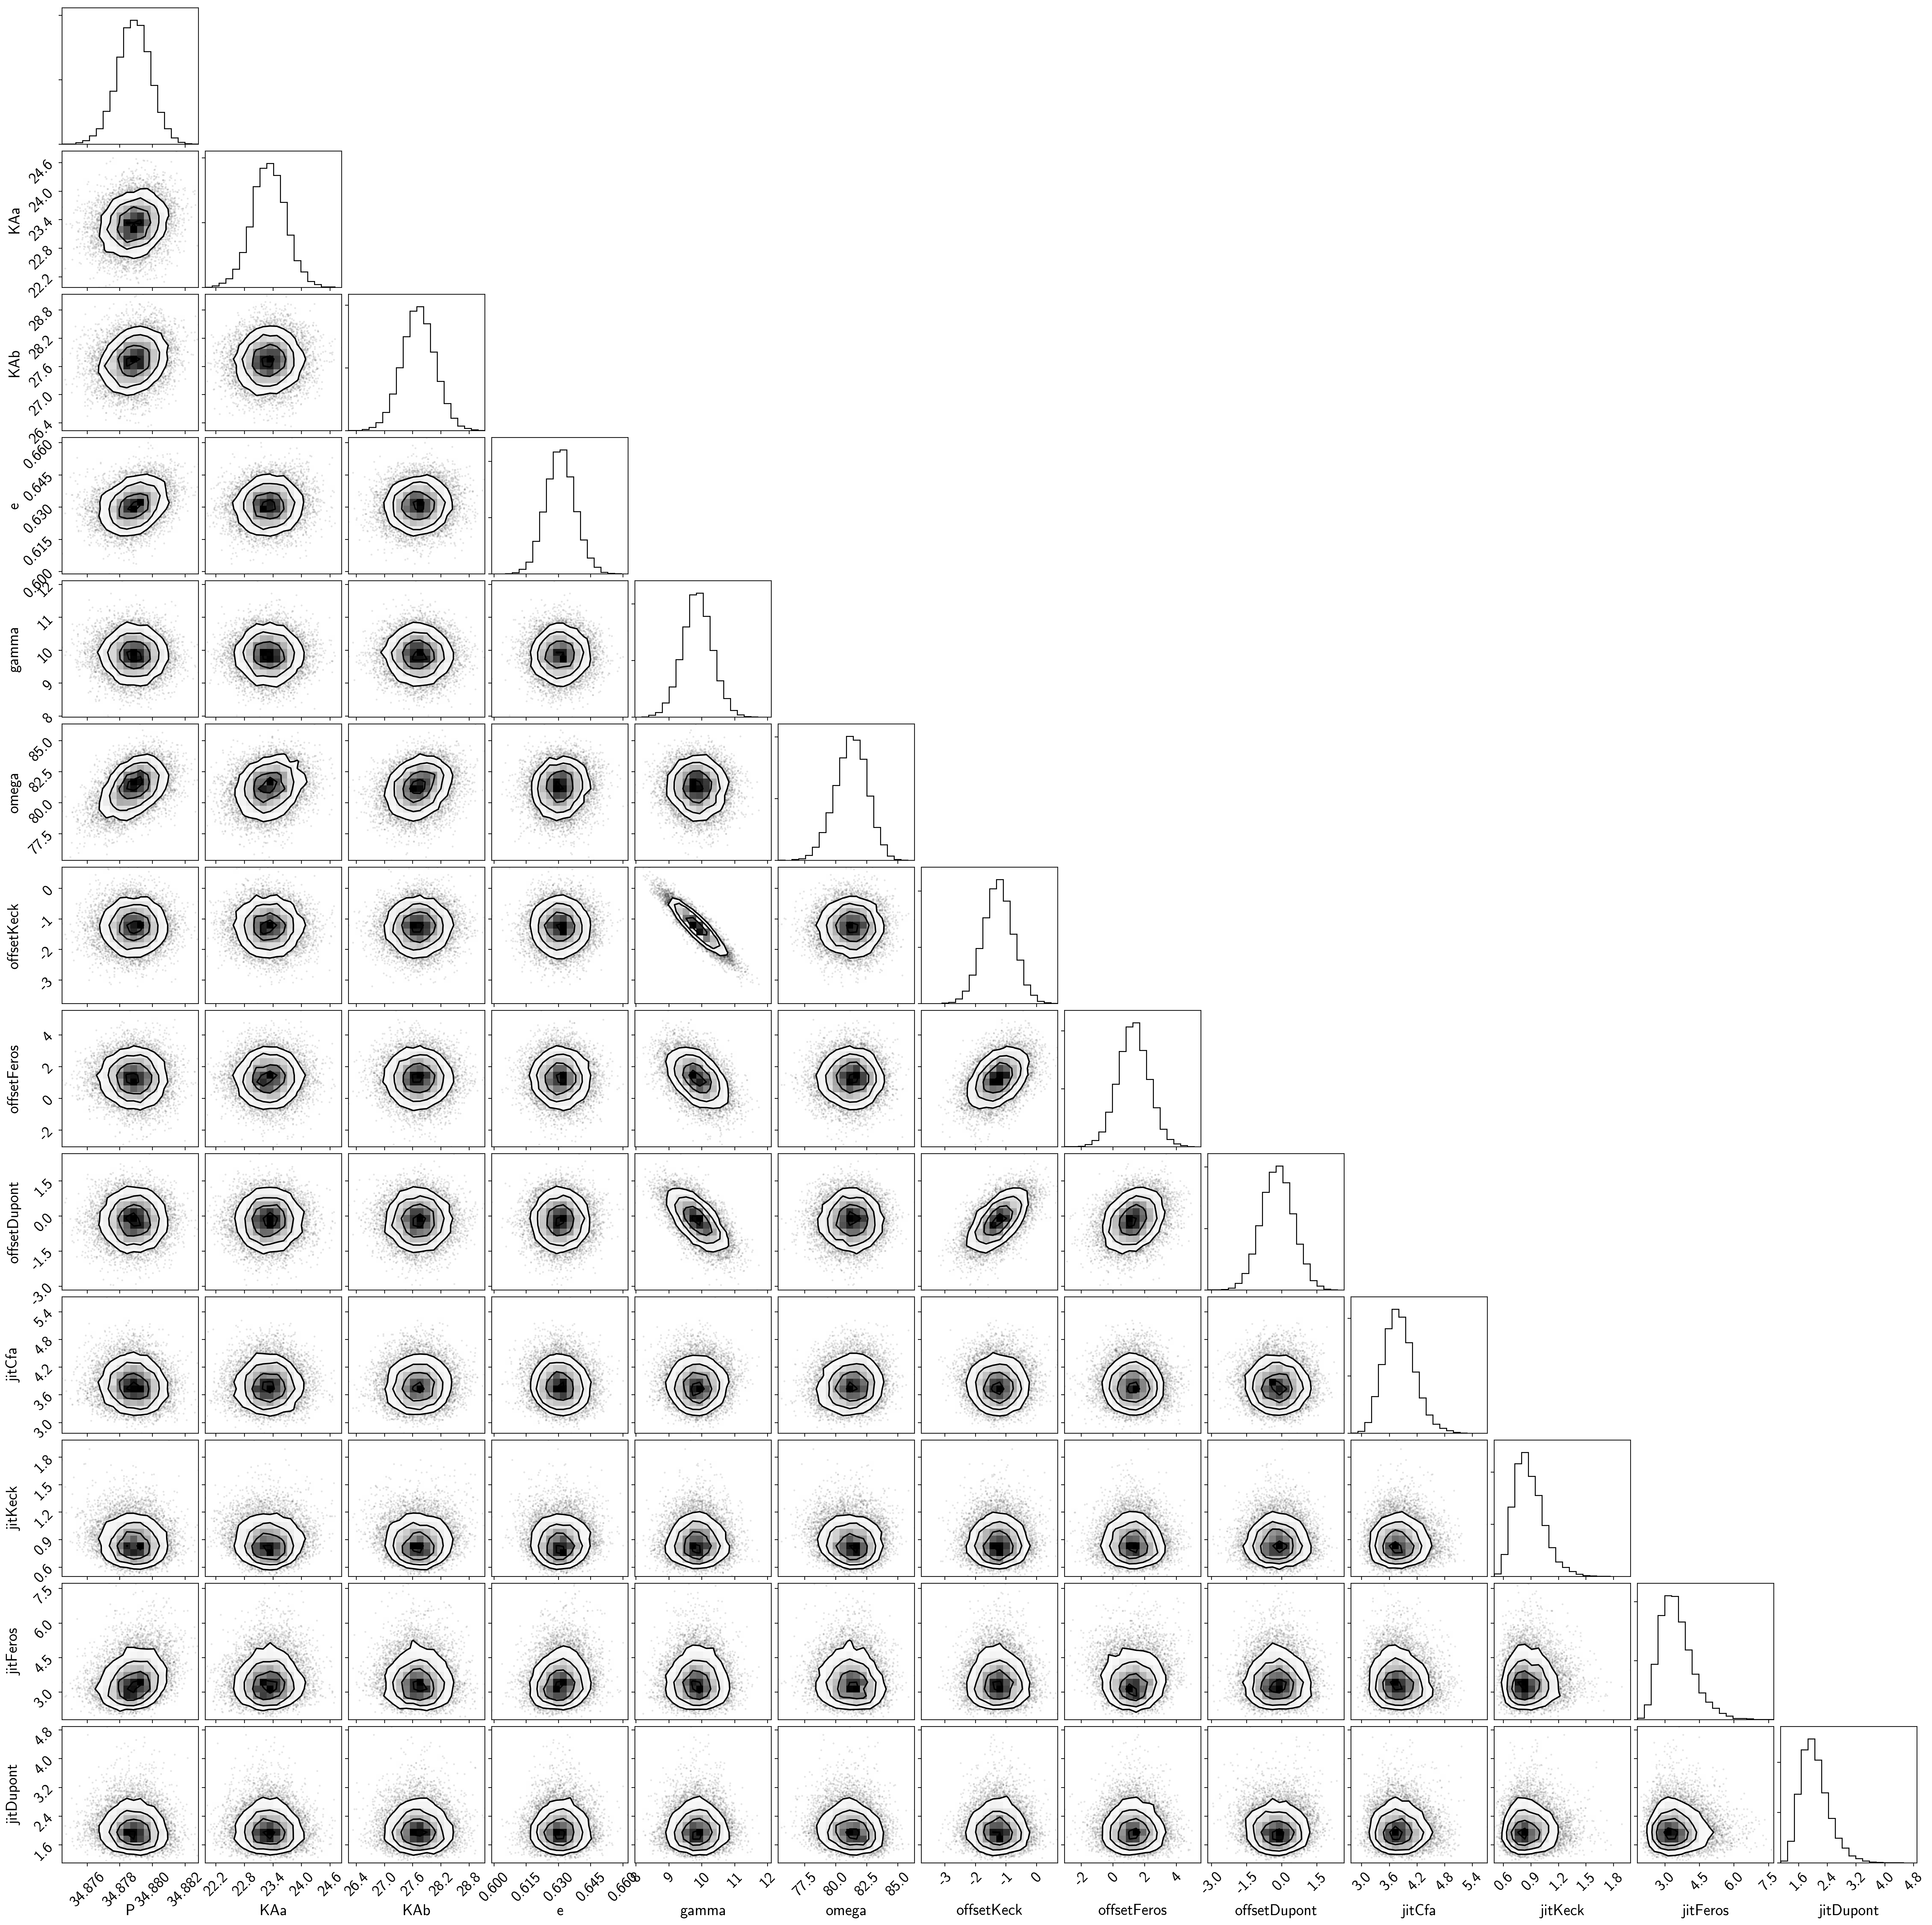

In [168]:
samples = pm.trace_to_dataframe(trace, varnames=["P", "KAa", "KAb", "e", "gamma", "omega", 
                                                 "offsetKeck", "offsetFeros", "offsetDupont",
                                                "jitCfa", "jitKeck", "jitFeros", "jitDupont"])
samples["omega"] /= deg
corner.corner(samples);